In [ ]:
from google.colab import auth, drive
# auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -f data
!ln -s "/content/drive/MyDrive/Colab Notebooks/COMP4332/Project 1/data" data

# General pipeline for project 1
This is an example pipeline showing you how to  
(1) Load the provided data;  
(2) Train models on the train set, and use the validation set to evaluate your model performance;  
(3) Generate predictions (pred.csv) on the test set, which is ready for submission.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

### (1) Loading data
The following code shows how to load the datasets for this project.  
Among which, we do not release the labels (the "stars" column) for the test set. You may evaluate your trained model on the validation set instead.

However, your submitted predictions (``pred.csv``) should be generated on the test set.

In [ ]:
def load_data(split_name='train', columns=['text', 'stars'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.
        
        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "stars" column is the labels (sentiment). 
        If you like, you are free to use columns other than "text" for prediction.
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

In [ ]:
train_df = load_data('train', columns=['text', 'stars'])
valid_df = load_data('valid', columns=['text', 'stars'])
test_df = load_data('test', columns=['text', 'review_id'])

select [text, stars] columns from the train split
Success
select [text, stars] columns from the valid split
Success
select [text, review_id] columns from the test split
Success


In [ ]:
print(train_df['stars'].value_counts(),
      valid_df['stars'].value_counts(),
      train_df.head(5), sep='\n'
)

5    7911
4    3971
1    2672
3    1989
2    1457
Name: stars, dtype: int64
5    904
4    466
1    282
3    212
2    136
Name: stars, dtype: int64
                                                text  stars
0  I've been here a handful of times now and I've...      5
1  The service was terrible. The food was just ok...      1
2  Alil pricey for the location but completly get...      4
3  Don't get your car washed here. Paid 11 and my...      1
4  Cute but tight. Not expensive and creative. I ...      5


In [ ]:
# Prepare the data.
# As an example, we only use the text data. 
x_train = train_df['text']
y_train = train_df['stars']#.apply(lambda x: 3 if (2 <= x and x <= 4) else x)

x_valid = valid_df['text']
y_valid = valid_df['stars']#.apply(lambda x: 3 if (2 <= x and x <= 4) else x)

x_test = test_df['text']

### (1.1) Data Exploration

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = set(stopwords.words("english"))
print(sw)
# all are important words for sentiment analysis @@

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'wasn', "hadn't", "mightn't", 'should', 'only', 'into', "it's", "won't", 'and', 'by', 'didn', 'between', "isn't", 'couldn', 'y', 'wouldn', 'myself', 'which', 'he', 'now', 'himself', 'had', 're', "wouldn't", "couldn't", 'nor', 'isn', "shouldn't", 'from', 'my', 'does', 'doing', 'own', 'very', 'be', 'when', 'being', 'doesn', 'don', 'who', 'have', "weren't", 'ain', 'ours', "mustn't", 'in', 'his', 'about', 'on', 'are', 'not', 'whom', 'its', 'that', "should've", "doesn't", 'over', 'mustn', 'for', "aren't", 'at', 'most', 'up', 'during', "you'd", 'off', 'there', 'a', 'here', 'ourselves', 'i', 'down', 'than', 'of', 'haven', 'been', 'mightn', 'd', 'yours', "you'll", 'then', 'we', 'if', 'those', 'few', 'ma', 'having', 'with', 'an', "haven't", 'has', 'what', 'but', 'to', 'once', 'before', "needn't", 'any', 'won', 've', 's', "you're", 'until', 'under', 'hers', 'was', 'each', "don'

In [ ]:
pattern = 'best'
for i in range(1,6):
    print(sum((x_train.apply(lambda x: pattern in x) * (y_train == i)).astype('int32'))/y_train.value_counts()[i],
          sum((x_valid.apply(lambda x: pattern in x) * (y_valid == i)).astype('int32'))/y_valid.value_counts()[i])

0.053517964071856286 0.05673758865248227
0.10020590253946465 0.08823529411764706
0.10055304172951232 0.13679245283018868
0.12364643666582725 0.10085836909871244
0.1776008090001264 0.17256637168141592


#### tSNE plot

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def plot_scatter(tsne_data, colors):
    # choose a color palette with seaborn.
    tsne_data = np.vstack((tsne_data.T, colors)).T
    tsne_df = pd.DataFrame(data = tsne_data,
         columns =("Dim_1", "Dim_2", "label"))
      
    # Ploting the result of tsne
    sns.FacetGrid(tsne_df, hue ="label", size = 6).map(
           plt.scatter, 'Dim_1', 'Dim_2').add_legend()
      
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


x_tsne [[ 1.7181067  -0.79541916]
 [-4.0259523  -2.400375  ]
 [-6.1131706  -0.6650334 ]
 ...
 [-1.5159316  -0.662876  ]
 [-0.17392826  3.3385053 ]
 [ 1.2614019   1.1576364 ]]
y [5 4 4 ... 5 5 5]


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


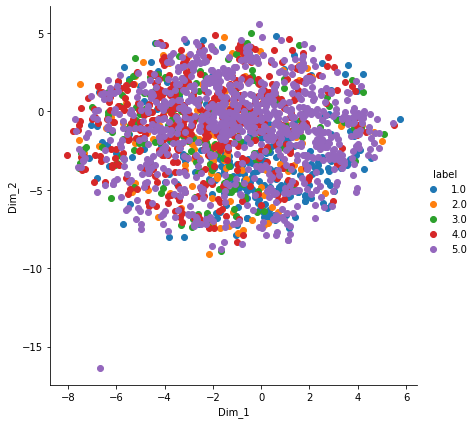

In [ ]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf.fit(x_train)
x_embeds = tfidf.transform(x_valid)

x_tsne = TSNE().fit_transform(x_embeds)
y = np.array(y_valid)
print('x_tsne',x_tsne)
print('y',y)

plot_scatter(x_tsne, y)
# too many data of high dimension -> tSNE plot is not meaningful

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


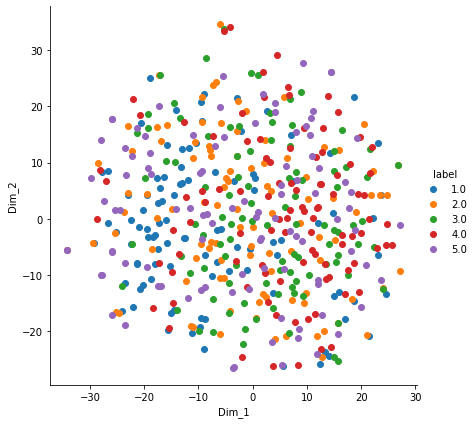

In [ ]:
# use smaller set of data
aggre_df = pd.DataFrame({'text':[], 'stars':[]})
num_per_class = 100

for s in range(1,6):
    temp = train_df[train_df['stars']==s]
    aggre_df = aggre_df.append(temp[:num_per_class])

x_embeds = tfidf.transform(aggre_df['text'])

x_tsne = TSNE().fit_transform(x_embeds)
y = np.array(aggre_df['stars'])

plot_scatter(x_tsne, y)
# still very chaostic

In [ ]:
tfidf_bingliu = TfidfVectorizer(vocabulary=set(bingliu_svocab))
tfidf_bingliu.fit(aggre_df['text'])

x_embeds = tfidf_bingliu.transform(aggre_df['text'])

x_tsne = TSNE().fit_transform(x_embeds)
y = np.array(aggre_df['stars'])

plot_scatter(x_tsne, y)
# still very chaotic

#### Wordcloud to observe word frequency

In [ ]:
from collections import Counter
from wordcloud.wordcloud import WordCloud, STOPWORDS

# let see which words exist the most in each 'voting' class
most_common_words = [[] for i in range(5)]

for v in range(1,6):
    corpus = ' '.join(train_df['text'][train_df['stars'] == v].to_list())
    bow = corpus.lower().split(' ')
    count_list = Counter(bow)
    print('-'*10, 'voting {}'.format(v), '-'*10)
    for w, c in count_list.most_common(200):
        if w not in STOPWORDS: # stopwords.words('english'):
            print(w, c)
            most_common_words[v-1].append(w)

In [ ]:
bow = []
for i in range(5):
    bow += most_common_words[i]
count_list = Counter(bow)
for w,c in count_list.most_common():
    print(w, c)

In [ ]:
for i in range(5):
    for j in range(i+1,5):
        print(i,j)
        mcw_i = most_common_words[i]
        mcw_j = most_common_words[j]
        print('set {} minus set {}'.format(i+1,j+1), set(mcw_i).difference(mcw_j))
        print('set {} minus set {}'.format(j+1,i+1), set(mcw_j).difference(mcw_i))

### (2) Training and validating
The following example shows you how to train your model using the train set, and evaluate on the validation set.  
As an example, we only use the text data for training. Feel free to use other columns in your implementation.  

The model performance on the validation set can be roughly regarded as your models final performance, so we can use it to search for optimal hyper-parameters.


Validation Performance | Macro-F1|Precision	|Recall|Accuracy
-----------------------|---------|----------|------|--------
Weak baseline	| 0.4270|0.5420 |0.4325|0.6135
Strong baseline | 0.5370|


Our model | Marco-F1 | Note
----------|----------|--------
SGDClassifier(loss='log', alpha=1) | 0.1245 | all predictions are 5
MultinomialNB() | 0.15x | most of predictions are 5
MultinomialNB(alpha=0.001) | 0.3966 | not good
-- LogisticR, fixed plain Tfidf() | | NOTE: weight scaling DOES affect model performance
(C=1, class_weight=None) | 0.5279 | a bit worse than strong baseline
(C=1, class_weight=[3,6,4,2,1]) | 0.54x |
(C=2, class_weight=None) | 0.5362 | better
(C=2, class_weight='balanced') | 0.542 | better
(C=2, class_weight=[3,6,4,2,1]) | 0.5460 |
(C=2, class_weight=[3,10,10,2,1]) | 0.526 |
(C=3, class_weight=[3,6,4,2,1]) | 0.5465 |
-- Tfidf, fixed LR(C=3,cw=[3,6,4,2,1]) 
ngram=(1,2) | 0.5563 | better
ngram=(1,2), max_features=10000, binary=False | 0.5511 | DON'T use binarize vector! (actually use low_case=False)
ngram=(1,2), max_features=10000, binary=True | 0.5247 | use low_case=False
ngram=(1,2), max_features=30000, low_case=False | 0.5602 
ngram=(1,4) (yield 3m500k tokens @@) | 0.5730 | OMG!, but cost 6 mins instead of 15s, and acc is roughly the same at 0.65x
ngram=(1,4), lowercase=False | 0.5533 | @@ 7m20s to train, acc 0.6465
ngram=(1,4), max_features=30000, low_case=False | 0.5627 | ->> **best** + cheap
 + max_df=0.9 (min_df=5) | 0.55xx | accuracy also decreases to 0.63x
 + sublinear_tf=True, smooth_idf=True | 0.56x | acc=0.643, not improve
ngram=(1,4), max_features=30000 | 0.5512 | not recommended to use low_case=True as default 
ngram=(1,4), max_features=30000, low_case=False, stopw='english' | 0.5369 | accuracy also decreases -> don't use stop words @@ seem counter-intuitive!
ngram=(1,4), max_features=60000, low_case=False | 0.5489
ngram=(1,4), max_features=60000 | 0.5617 | wait, what?
-- MLPClassifier(hs=(100,)) | -- |fixed **best** Tfidf(ngram=(1,4), max_features=30000, low_case=False)
activation='relu', alpha=1e-2, lr="invscaling", 30 iters | 0.5647 | at iter 4
activation='relu', alpha=1e-2, lr="constant"/"adaptive", 10 iters | 0.5647 | at iter 4, no difference when using different lr
activation='relu', alpha=1e-2, lr_init = 0.0001 |  | learning slower vs default lr_init=0.001
activation='relu', alpha=1e-2, lr_init = 0.01 | 0.55x | at iter 1, then decline -> use default
activation='relu', alpha=1e-3 | 0.5585 | no diff, seem that param of MLP is not big
activation='relu', alpha=1e-1 | 0.5656 | at iter 9, then stable at 0.55x
activation='logistic', alpha=1e-1 | 0.264 | at iter 20/20, slowly better
activation='tanh', alpha=1e-1 | 0.5607 | at iter 8/20, slowly better
-- How many epochs to fit LR
200 | 0.5558
100 | 0.5627
50 | 0.5573
-- Ensemble
135 ([3,1,1]), 234 ([3,2,1]) | 0.5677


'LogisticRegression' object has no attribute 'partial_fit'

Using np.array is slower to fit LR than sparse matrix (output of tfidf)

Models will be evaluated by [Macro F1](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#989c)(unweighted avg of F1 score per class) on test data

In [ ]:
import string, nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def text_clean(message):
    nopunc = [i for i in message if i not in string.punctuation]
    nn = "".join(nopunc)
    nn = nn.lower().split()
    nostop = [words for words in nn if words not in stopwords.words('english')]
    return(nostop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
## display loss during training
# https://stackoverflow.com/questions/44443479/python-sklearn-show-loss-values-during-training

import sys
import io
import matplotlib.pyplot as plt

class DisplayLossCurve(object):
  def __init__(self, print_loss=False):
    self.print_loss = print_loss

  """Make sure the model verbose is set to 1"""
  def __enter__(self):
    self.old_stdout = sys.stdout
    sys.stdout = self.mystdout = io.StringIO()
  
  def __exit__(self, *args, **kwargs):
    sys.stdout = self.old_stdout
    loss_history = self.mystdout.getvalue()
    loss_list = []
    for line in loss_history.split('\n'):
      if(len(line.split("loss: ")) == 1):
        continue
      loss_list.append(float(line.split("loss: ")[-1]))
    plt.figure()
    plt.plot(np.arange(len(loss_list)), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    if self.print_loss:
      print("=============== Loss Array ===============")
      print(np.array(loss_list))
      
    return True

 You can use the valid data to choose the hyperparameters.
As an example, you can decide which value of C (1 or 100) is better by evaluating on the valid data.

#### Get Tfidf embedding

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,4), #max_df=0.9, min_df=5,
                        max_features=30000,
                        lowercase=False)

x_train_embeds = tfidf.fit_transform(x_train)
x_valid_embeds = tfidf.transform(x_valid)

In [ ]:
x_valid_embeds.shape

(2000, 30000)

#### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp1 = MLPClassifier(activation='relu',
                     alpha=1e-1,
                     random_state=44,
                     max_iter=100)

for i in range(1,15):
    mlp1.partial_fit(x_train_embeds, y_train, [1,2,3,4,5])

    if i%1 == 0:
        # validate on the validation set
        y_pred = mlp1.predict(x_valid_embeds)
        print('After training {} iterations'.format(i))
        print(f1_score(y_valid, y_pred, average='macro'))

After training 1 iterations
0.30355209169373293
After training 2 iterations
0.41608223342162487
After training 3 iterations
0.4834339583467459
After training 4 iterations
0.5196737640087669
After training 5 iterations
0.544806287092283
After training 6 iterations
0.5532375722630112
After training 7 iterations
0.554382874639308
After training 8 iterations
0.5571202719848026
After training 9 iterations
0.5642986482108558
After training 10 iterations
0.5656606183807659
After training 11 iterations
0.5644133156687069
After training 12 iterations
0.5602356080758004
After training 13 iterations
0.5618450034608076


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


After training 14 iterations
0.5503206910314226
After training 15 iterations
0.5658156897478644
After training 16 iterations
0.5571821294984804
After training 17 iterations
0.5560734564075119
After training 18 iterations
0.548130377546497
After training 19 iterations
0.5457372075374047


#### Model 2

In [ ]:
lr2 = LogisticRegression(C=3,
                         class_weight={i+1: w for i,w in enumerate([3,6,4,2,1])}
                         )

# train the second model
lr2.fit(x_train_embeds, y_train)

# validate on the validation set
y_pred = lr2.predict(x_valid_embeds)
print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1     0.7061    0.7837    0.7429       282
           2     0.3380    0.3529    0.3453       136
           3     0.4155    0.4057    0.4105       212
           4     0.5139    0.5536    0.5331       466
           5     0.8134    0.7522    0.7816       904

    accuracy                         0.6465      2000
   macro avg     0.5574    0.5696    0.5627      2000
weighted avg     0.6540    0.6465    0.6492      2000




[[221  33  16   6   6]
 [ 43  48  37   7   1]
 [ 19  36  86  56  15]
 [ 13  16  45 258 134]
 [ 17   9  23 175 680]]
accuracy 0.6465


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
lr2 = LogisticRegression(C=3,
                         class_weight={i+1: w for i,w in enumerate([3,6,4,2,1])},
                         solver='liblinear', random_state=1
                         )

# train the second model
lr2.fit(x_train_embeds, y_train)

# validate on the validation set
y_pred = lr2.predict(x_valid_embeds)
print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

              precision    recall  f1-score   support

           1     0.6939    0.8121    0.7484       282
           2     0.3475    0.3015    0.3228       136
           3     0.4144    0.3538    0.3817       212
           4     0.5140    0.4742    0.4933       466
           5     0.7843    0.8164    0.8000       904

    accuracy                         0.6520      2000
   macro avg     0.5508    0.5516    0.5492      2000
weighted avg     0.6396    0.6520    0.6445      2000




[[229  26  13   6   8]
 [ 49  41  38   7   1]
 [ 22  31  75  67  17]
 [ 14  15  39 221 177]
 [ 16   5  16 129 738]]
accuracy 0.652


In [ ]:
LogisticRegression?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__C':[0.1,0.3,1,3,10,30,100]
}

gs_pipe2 = GridSearchCV(pipe2, param_grid, scoring='f1_macro')
gs_pipe2.fit(x_train, y_train)

print(
    gs_pipe2.best_score_,
    gs_pipe2.best_params_,
    sep='\n'
)

Let see how the model fit to train data

In [ ]:
# on train set
y_pred = pipe2.predict(x_train)
print(classification_report(y_train, y_pred))
print("\n\n")
print(confusion_matrix(y_train, y_pred))
print('accuracy', np.mean(y_train == y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2672
           2       1.00      1.00      1.00      1457
           3       1.00      1.00      1.00      1989
           4       1.00      1.00      1.00      3971
           5       1.00      1.00      1.00      7911

    accuracy                           1.00     18000
   macro avg       1.00      1.00      1.00     18000
weighted avg       1.00      1.00      1.00     18000




[[2672    0    0    0    0]
 [   0 1457    0    0    0]
 [   0    0 1989    0    0]
 [   0    0    0 3971    0]
 [   1    1    1    0 7908]]
accuracy 0.9998333333333334


#### Experiment with various models 

[Naive Bayes](https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a)
[Light GBM](https://stackoverflow.com/questions/50250432/python-lightgbm-text-classicication-with-tfidf)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)

neigh.fit(x_train_embeds, y_train)
y_pred = neigh.predict(x_valid_embeds)

print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))

              precision    recall  f1-score   support

           1     0.4448    0.5000    0.4708       282
           2     0.0620    0.7647    0.1147       136
           3     1.0000    0.0094    0.0187       212
           4     1.0000    0.0021    0.0043       466
           5     0.0000    0.0000    0.0000       904

    accuracy                         0.1240      2000
   macro avg     0.5014    0.2553    0.1217      2000
weighted avg     0.4059    0.1240    0.0772      2000




[[141 141   0   0   0]
 [ 32 104   0   0   0]
 [ 27 182   2   0   1]
 [ 42 422   0   1   1]
 [ 75 829   0   0   0]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(criterion='entropy', 
                                  class_weight={i+1: w for i,w in enumerate([3,6,4,2,1])},
                                  )
clf_RF.fit(x_train_embeds, y_train)
y_pred = clf_RF.predict(x_valid_embeds)

print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))

              precision    recall  f1-score   support

           1     0.6713    0.5142    0.5823       282
           2     0.2500    0.0074    0.0143       136
           3     0.7000    0.0330    0.0631       212
           4     0.3359    0.0944    0.1474       466
           5     0.5278    0.9569    0.6803       904

    accuracy                         0.5310      2000
   macro avg     0.4970    0.3212    0.2975      2000
weighted avg     0.5027    0.5310    0.4316      2000




[[145   2   0   6 129]
 [ 36   1   2  12  85]
 [ 12   0   7  44 149]
 [ 10   0   1  44 411]
 [ 13   1   0  25 865]]


In [ ]:
import lightgbm as lgbm
from lightgbm import LGBMClassifier, LGBMRegressor

clf_LGBM = lgbm.LGBMClassifier(objective='multiclass', verbose=-1, learning_rate=0.01, max_depth=20, 
                               num_leaves=32, n_estimators=120, max_bin=200, 
                            #    class_weight={i: w for i,w in enumerate([3,6,4,2,1])} # not use class weight -> 0.51
                               )
clf_LGBM.fit(x_train_embeds, y_train-1, verbose=True)
y_pred = clf_LGBM.predict(x_valid_embeds)

print(classification_report(y_valid-1, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid-1, y_pred))

              precision    recall  f1-score   support

           0     0.7006    0.4397    0.5403       282
           1     1.0000    0.0221    0.0432       136
           2     0.5000    0.0047    0.0093       212
           3     0.4184    0.0880    0.1454       466
           4     0.5116    0.9735    0.6707       904

    accuracy                         0.5245      2000
   macro avg     0.6261    0.3056    0.2818      2000
weighted avg     0.5485    0.5245    0.4172      2000




[[124   0   0   5 153]
 [ 25   3   1   8  99]
 [ 14   0   1  25 172]
 [  9   0   0  41 416]
 [  5   0   0  19 880]]


In [ ]:
from sklearn.naive_bayes import MultinomialNB

# build the second linear model with TFIDF feature
tfidf = TfidfVectorizer()

lr2 = MultinomialNB(alpha= 0.001)
steps = [('tfidf', tfidf),('lr', lr2)]
pipe2 = Pipeline(steps)

# train the second model
pipe2.fit(x_train, y_train)

# validate on the validation set
y_pred = pipe2.predict(x_valid)
print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

#### Ensemble of two LogisticReg

Our model | Marco-F1 | Accuracy | Note
----------|----------|----------|------
-- lr_135
w=[3,1,1] | 0.7574
w=[1,1,1] | 0.7487
w=[5,1,1] | 0.7517
-- Ensemble
135 ([3,1,1]), 234 ([3,2,1]) | 0.5677 
135 ([3,1,1]), 234 ([5,3,1]) | 0.5636 
135 ([3,1,1]), 234 ([10,5,1]) | 0.5569  
135 ([1,3,1]), 234 ([3,2,1]) | 0.5414 | 0.6020
135 ([2,1,1]), 234 ([3,2,1]) | 0.5651 | 0.6530  
135 (balanced), 234 (balanced) | 0.5654 | 0.6525 
- 12 + 45 + 135 cw
balanced balanced balanced  | 0.5585 | 0.6385
[2,4,1] balanced balanced  | 0.5763 | 0.657
[2,4,1] [2,3] balanced  | 0.5732 | 0.657
[2,4,1] [2,3] [3,2]  | 0.5711 | 0.6605
[1,3,1] balanced balanced | 0.5755 |0.6575    
(try other weight, just get similar result)

##### 135 + 234

In [ ]:
y_train_135 = y_train.copy()
y_train_135[y_train_135.between(2,4)] = 3
print(np.unique(y_train_135))

y_valid_135 = y_valid.copy()
y_valid_135[y_valid_135.between(2,4)] = 3
print(np.unique(y_valid_135))

In [ ]:
# x_train_embeds = tfidf.transform(x_train)

x_train_embeds_234 = tfidf.transform(x_train[y_train_135==3])
y_train_234 = y_train[y_train_135==3]
print(x_train_embeds_234, len(y_train_234))

x_valid_embeds_234 = tfidf.transform(x_valid[y_valid_135==3])
y_valid_234 = y_valid[y_valid_135==3]
print(x_valid_embeds_234, len(y_valid_234))

In [ ]:
lr_135 = LogisticRegression(C=3, max_iter=100,
                         class_weight='balanced' #{i: w for i,w in zip([1,3,5],[3,1,1])}
                         )

lr_135.fit(x_train_embeds, y_train_135)

# validate on the validation set
y_pred_135 = lr_135.predict(x_valid_embeds)
print(classification_report(y_valid_135, y_pred_135, digits=4))
print("\n\n")
print(confusion_matrix(y_valid_135, y_pred_135))
print('accuracy', np.mean(y_valid_135 == y_pred_135))

In [ ]:
lr_234 = LogisticRegression(C=3, max_iter=100,
                         class_weight='balanced' #{i: w for i,w in zip([2,3,4],[3,2,1])}
                         )

lr_234.fit(x_train_embeds_234, y_train_234)

# validate on the validation set
y_pred_234 = lr_234.predict(x_valid_embeds_234)
print(classification_report(y_valid_234, y_pred_234, digits=4))
print("\n\n")
print(confusion_matrix(y_valid_234, y_pred_234))
print('accuracy', np.mean(y_valid_234 == y_pred_234))

In [ ]:
## end-to-end prediction
y_pred_135 = lr_135.predict(x_valid_embeds)
x_valid_embeds_3 = tfidf.transform(x_valid[y_pred_135==3])
y_pred_234 = lr_234.predict(x_valid_embeds_3)

y_pred = y_pred_135.copy()
y_pred[y_pred==3] = y_pred_234

print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

##### 12 + 45 + 135

In [ ]:
y_train_135 = y_train.copy()
y_train_135[y_train_135 < 3] = 1
y_train_135[y_train_135 > 3] = 5
print(np.unique(y_train_135))

y_valid_135 = y_valid.copy()
y_valid_135[y_valid_135 < 3] = 1
y_valid_135[y_valid_135 > 3] = 5
print(np.unique(y_valid_135))

In [ ]:
y_train_12 = y_train.copy()
y_train_12 = y_train_12[y_train_12 < 3]
print(np.unique(y_train_12))

y_valid_12 = y_valid.copy()
y_valid_12 = y_valid_12[y_valid_12 < 3]
print(np.unique(y_valid_12))

In [ ]:
y_train_45 = y_train.copy()
y_train_45 = y_train_45[y_train_45 > 3]
print(np.unique(y_train_45))

y_valid_45 = y_valid.copy()
y_valid_45 = y_valid_45[y_valid_45 > 3]
print(np.unique(y_valid_45))

Our model | Marco-F1 | Accuracy |class 3| Note
----------|----------|----------|-|------
-- lr_135
1,3,1 | 0.7382 | 0.8570 | 
1,10,1 | 0.7271 | 0.8350 |
balanced | 0.7300 | 0.8415 | 
2,4,1 | 0.7324 | 0.8565 | 0.4539
2,6,1 | 0.7342 | 0.8465 | 0.4719

Need to raise score of class 3

In [ ]:
lr_135 = LogisticRegression(C=3, max_iter=100,
                         class_weight={i: w for i,w in zip([1,3,5],[2,4,1])}
                         )

lr_135.fit(x_train_embeds, y_train_135)

# validate on the validation set
y_pred_135 = lr_135.predict(x_valid_embeds)
print(classification_report(y_valid_135, y_pred_135, digits=4))
print("\n\n")
print(confusion_matrix(y_valid_135, y_pred_135))
# print('accuracy', np.mean(y_valid_135 == y_pred_135))

In [ ]:
x_train_embeds_12 = tfidf.transform(x_train[y_train < 3])
y_train_12 = y_train[y_train < 3]
# print(x_train_embeds_12, len(y_train_12))

x_valid_embeds_12 = tfidf.transform(x_valid[y_valid < 3])
y_valid_12 = y_valid[y_valid < 3]
# print(x_valid_embeds_12, len(y_valid_12))

In [ ]:
x_train_embeds_45 = tfidf.transform(x_train[y_train > 3])
y_train_45 = y_train[y_train > 3]
# print(x_train_embeds_45, len(y_train_45))

x_valid_embeds_45 = tfidf.transform(x_valid[y_valid > 3])
y_valid_45 = y_valid[y_valid > 3]
# print(x_valid_embeds_45, len(y_valid_45))

In [ ]:
lr_12 = LogisticRegression(C=3, max_iter=100,
                         class_weight='balanced'#{i: w for i,w in zip([1,2],[2,3])}
                         )

lr_12.fit(x_train_embeds_12, y_train_12)

# validate on the validation set
y_pred_12 = lr_12.predict(x_valid_embeds_12)
print(classification_report(y_valid_12, y_pred_12, digits=4))
print("\n\n")
print(confusion_matrix(y_valid_12, y_pred_12))
print('accuracy', np.mean(y_valid_12 == y_pred_12))

In [ ]:
lr_45 = LogisticRegression(C=3, max_iter=100,
                         class_weight='balanced'#{i: w for i,w in zip([4,5],[6,4])}
                         )

lr_45.fit(x_train_embeds_45, y_train_45)

# validate on the validation set
y_pred_45 = lr_45.predict(x_valid_embeds_45)
print(classification_report(y_valid_45, y_pred_45, digits=4))
print("\n\n")
print(confusion_matrix(y_valid_45, y_pred_45))
print('accuracy', np.mean(y_valid_45 == y_pred_45))

In [ ]:
## end-to-end prediction
y_pred_135 = lr_135.predict(x_valid_embeds)
x_valid_embeds_1 = tfidf.transform(x_valid[y_pred_135==1])
x_valid_embeds_5 = tfidf.transform(x_valid[y_pred_135==5])

y_pred_12 = lr_12.predict(x_valid_embeds_1)
y_pred_45 = lr_45.predict(x_valid_embeds_5)

y_pred = y_pred_135.copy()
y_pred[y_pred==1] = y_pred_12
y_pred[y_pred==5] = y_pred_45

print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

#### Reserved

In [ ]:
# build the second linear model with TFIDF feature
tfidf = TfidfVectorizer(ngram_range=(1,4),
                        # lowercase=False,
                        # max_features=30000
                        )

lr2 = LogisticRegression(C=3,
                         class_weight={i+1: w for i,w in enumerate([3,6,4,2,1])}
                         )
steps = [('tfidf', tfidf),('lr', lr2)]
pipe2 = Pipeline(steps)

# train the second model
pipe2.fit(x_train, y_train)

# validate on the validation set
y_pred = pipe2.predict(x_valid)
print(classification_report(y_valid, y_pred, digits=4))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           1     0.6928    0.8156    0.7492       282
           2     0.3966    0.3382    0.3651       136
           3     0.4555    0.4104    0.4318       212
           4     0.5100    0.5472    0.5280       466
           5     0.8107    0.7721    0.7909       904

    accuracy                         0.6580      2000
   macro avg     0.5731    0.5767    0.5730      2000
weighted avg     0.6582    0.6580    0.6567      2000




[[230  27  11   8   6]
 [ 42  46  35  11   2]
 [ 22  24  87  65  14]
 [ 18  11  41 255 141]
 [ 20   8  17 161 698]]
accuracy 0.658


In [ ]:
# validate on the validation set
y_pred = pipe.predict(valid_df_234['text'])
print(classification_report(valid_df_234['stars'], y_pred, digits=4))
print("\n\n")
print(confusion_matrix(valid_df_234['stars'], y_pred))
print('accuracy', np.mean(valid_df_234['stars'] == y_pred))

In [ ]:
train_df_234 = train_df[train_df['stars'].between(2,4)]
valid_df_234 = valid_df[valid_df['stars'].between(2,4)]

# build the second linear model with TFIDF feature
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
lr = LogisticRegression(C=1)
steps = [('tfidf', tfidf),('clf', lr)]
pipe = Pipeline(steps)

# train the second model
pipe.fit(train_df_234['text'], train_df_234['stars'])

# validate on the validation set
y_pred = pipe.predict(valid_df_234['text'])
print(classification_report(valid_df_234['stars'], y_pred, digits=4))
print("\n\n")
print(confusion_matrix(valid_df_234['stars'], y_pred))
print('accuracy', np.mean(valid_df_234['stars'] == y_pred))

              precision    recall  f1-score   support

           2     0.5600    0.4118    0.4746       136
           3     0.5071    0.3349    0.4034       212
           4     0.7404    0.9120    0.8173       466

    accuracy                         0.6781       814
   macro avg     0.6025    0.5529    0.5651       814
weighted avg     0.6495    0.6781    0.6522       814




[[ 56  44  36]
 [ 28  71 113]
 [ 16  25 425]]
accuracy 0.6781326781326781


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


##### Sentiment Lexicon (Bingliu)

In [ ]:
# error: cannot decode byte
# solved: https://stackoverflow.com/questions/19699367/for-line-in-results-in-unicodedecodeerror-utf-8-codec-cant-decode-byte
# change encoding style
f = open('/content/drive/MyDrive/Comp 4332/Project 1/sentiment-lexicon/bing-liu/negative-words.txt', 
                 'r', encoding='ISO-8859-1')

for line in f:
    continue

In [ ]:
def load_bingliu_lexicon():
    svocab = []
    for polar in ['positive', 'negative']:
        f = open('/content/drive/MyDrive/Comp 4332/Project 1/sentiment-lexicon/bing-liu/{}-words.txt'.format(polar), 
                 'r', encoding='ISO-8859-1')
        
        svocab.extend(f.read().strip().split('\n'))
        f.close()
    return svocab

bingliu_svocab = load_bingliu_lexicon()
print(len(bingliu_svocab))

6789


In [ ]:
# TODO: add vocab list from some popular source for sentiment analysis

tfidf = TfidfVectorizer(vocabulary=set(bingliu_svocab))
lr1 = LogisticRegression(C=10,
                         max_iter=100,
                         class_weight=None,
                         random_state=328)
steps = [('tfidf', tfidf),('lr', lr1)]
pipe1 = Pipeline(steps)

# train the first model
pipe1.fit(x_train, y_train)

# validate on the validation set
y_pred = pipe1.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           1       0.59      0.70      0.64       282
           2       0.30      0.21      0.25       136
           3       0.30      0.19      0.24       212
           4       0.41      0.32      0.36       466
           5       0.68      0.80      0.73       904

    accuracy                           0.57      2000
   macro avg       0.46      0.45      0.44      2000
weighted avg       0.54      0.57      0.55      2000




[[198  30  13  17  24]
 [ 50  29  22  17  18]
 [ 34  26  41  59  52]
 [ 24   9  35 148 250]
 [ 28   4  25 122 725]]
accuracy 0.5705


Logistic model cannot converge!

##### Class-weighted loss

Discrimination between stars 2,3,4 is absent! Need to focus on those categories, by class weight!

* [1,3,3,3,1], [1,1,5,1,1] -> not good as unweight!
* bingliu_svocab -> decrease performance!!

In [ ]:
tfidf = TfidfVectorizer(vocabulary=set(bingliu_svocab))
lr2 = LogisticRegression(C=1,
                         max_iter=100,
                         class_weight={i+1: w for i,w in enumerate([1,1,5,1,1])},
                         random_state=328)
steps = [('tfidf', tfidf),('lr', lr2)]
pipe2 = Pipeline(steps)

# train the second model
pipe2.fit(x_train, y_train)

# on train set
y_pred = pipe2.predict(x_train)
print(classification_report(y_train, y_pred))
print("\n\n")
print(confusion_matrix(y_train, y_pred))
print('accuracy', np.mean(y_train == y_pred))

# validate on the validation set
y_pred = pipe2.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           1       0.80      0.68      0.74      2672
           2       0.75      0.06      0.11      1457
           3       0.29      0.90      0.44      1989
           4       0.66      0.19      0.29      3971
           5       0.77      0.81      0.79      7911

    accuracy                           0.60     18000
   macro avg       0.66      0.53      0.47     18000
weighted avg       0.70      0.60      0.58     18000




[[1811   22  715   11  113]
 [ 299   85  947   25  101]
 [  27    1 1792   31  138]
 [  49    3 1573  743 1603]
 [  65    2 1086  311 6447]]
accuracy 0.6043333333333333
              precision    recall  f1-score   support

           1       0.72      0.58      0.64       282
           2       0.43      0.04      0.08       136
           3       0.21      0.69      0.33       212
           4       0.38      0.11      0.16       466
           5       0.72      0.75      0.74       904

    accuracy 

 We find the second model (pipe2) has higher accuracy, then we use the second model to make predictions on test data. In practice, you may not only focus on the accuracy, but also other metrics (precision, recall, f1), since the label distribution is not always balanced.

### (3) Generate predictions on the test set

In [ ]:
x_test_embeds = tfidf.transform(x_test)

predict_test_135 = lr_135.predict(x_test_embeds)
x_test_embeds_1 = tfidf.transform(x_test[predict_test_135==1])
x_test_embeds_5 = tfidf.transform(x_test[predict_test_135==5])

predict_test_12 = lr_12.predict(x_test_embeds_1)
predict_test_45 = lr_45.predict(x_test_embeds_5)

predict_test = predict_test_135.copy()
predict_test[predict_test==1] = predict_test_12
predict_test[predict_test==5] = predict_test_45

In [ ]:
predict_test

array([5, 5, 2, ..., 2, 1, 2])

In [ ]:
# save your model predictions
pred_df = pd.DataFrame({'stars': predict_test, 'review_id': test_df['review_id']})
pred_df.to_csv('data/pred_StatML.csv', index=False)

 Then you may submit the predictions `pred.csv` on the test set. 